In [34]:
import os
os.chdir('/Users/schoens/Documents/PhD/IIASA/04_Code/income_decile_v2/')

In [47]:
from pathlib import Path

import pandas as pd 
import numpy as np
import xarray as xr
import geopandas as gpd 
from shapely import box
import pycountry

from tqdm.notebook import tqdm

import config.config as cfg 
from config.config import (PROCESSED_GMT_FILE,
                           GRAPHICS_DIR, GRAPHICS_PAPER_MAIN_DIR, GRAPHICS_PAPER_APPENDIX_DIR, 
                           RESULTS_DIR,
                           fontsize_medium,
                           fontsize_small,
                           fontsize_large, 
                           regions,
                           region_naming_dict, 
                           population_shares, 
                           group_colors,
                           uncertainty_color,
                           sensitvitiy_color,
                           symbols,
                           EU27_ids
                           )
from utils.plotting_functions import lighten_color

import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib
from matplotlib import colormaps as cmaps
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, to_rgba
import matplotlib.colors as cm
from scipy.stats import skewnorm

from tabulate import tabulate

from itertools import product

plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['font.sans-serif'] = 'Arial'

In [36]:
tas_frequency_df = xr.open_dataset(RESULTS_DIR / 'tas_frequency_hot.nc').stack(coords = ('lat', 'lon')).dropna('coords', how = 'all')
spei_frequency_df = xr.open_dataset(RESULTS_DIR / 'spei_frequency_dry.nc').stack(coords = ('lat', 'lon')).dropna('coords', how = 'all')
spi_frequency_df = xr.open_dataset(RESULTS_DIR / 'spi_frequency_dry.nc').stack(coords = ('lat', 'lon')).dropna('coords', how = 'all')
tas_intensity_df = xr.open_dataset(RESULTS_DIR / 'tas_intensity_hot.nc').stack(coords = ('lat', 'lon')).dropna('coords', how = 'all')
spei_intensity_df = xr.open_dataset(RESULTS_DIR / 'spei_intensity_dry.nc').stack(coords = ('lat', 'lon')).dropna('coords', how = 'all')
spi_intensity_df = xr.open_dataset(RESULTS_DIR / 'spi_intensity_dry.nc').stack(coords = ('lat', 'lon')).dropna('coords', how = 'all')

ds_coords = tas_frequency_df['coords']

In [37]:
cmap_spi = LinearSegmentedColormap.from_list(
    "", ["#e6e1da", "#ba8057", "#4f2a1a"], gamma=0.8
)

cmap_tas = LinearSegmentedColormap.from_list(
    "", ["#f2dfd7", "#ff7733", "#8c0c0c"], gamma=0.8
)

In [38]:
import regionmask 
import matplotlib.patches as patches
ar6 = regionmask.defined_regions.ar6.land
gdf = ar6.to_geodataframe()
gdf = gdf.set_index("abbrevs")
density = 4

def data_frequency_peak_month(var, region, group, extreme_quantile, extreme_type):

    frequency_df = xr.open_dataset(RESULTS_DIR / f'{var}_frequency_{extreme_type}.nc').stack(coords = ('lat', 'lon')).dropna('coords', how = 'all')

    idx_month = np.load(RESULTS_DIR / 'tas_hottest_month.npy')

    ttest = np.load(RESULTS_DIR / f'{var}_test_results_{region}_{group}_equal-scaling.npy')
    means = np.load(RESULTS_DIR / f'{var}_means_{region}_{group}_equal-scaling.npy')
    mask = (ttest > 0.05)

    df = frequency_df.sel(region = region, extreme_quantile = extreme_quantile)

    # only keep locations with significant difference in distributions
    tmp = df[f'attributed_{var}'].values
    sel = np.array([tmp[:, :, idx, i] for i, idx in enumerate(idx_month)]).T

    plot_df = xr.DataArray(data = sel, 
                        dims = ['model', 'group', 'coords'], 
                        coords = {'group': df.group,'model': df.model, 'coords': df['coords']})

    z_mean = plot_df.sel(group = group).mean(dim = 'model').unstack('coords').sortby('lon').values.T
    z_std = plot_df.sel(group = group).std(dim = 'model').unstack('coords').sortby('lon').values.T
    z_mean[np.isnan(z_mean)] = 1000
    z_std[np.isnan(z_std)] = 0 
    # z_std[np.abs(z_mean) <= 0.1] = 1000
    # z_mean[~np.isfinite(z_mean)] = 0
    # z_std[~np.isfinite(z_std)] = 0
    sel[sel < 0] = 0

    plot_df = xr.DataArray(data = sel, 
                        dims = ['model','group', 'coords'], 
                        coords = {'group': df.group, 'model': df.model, 'coords': df['coords']}).median(dim = 'model').unstack('coords').sortby('lon')
    
    return(plot_df, z_mean, z_std)

def data_frequency_month(var, month, region, group, extreme_quantile, extreme_type):

    frequency_df = xr.open_dataset(RESULTS_DIR / f'{var}_frequency_{extreme_type}.nc').stack(coords = ('lat', 'lon')).dropna('coords', how = 'all')

    ttest = np.load(RESULTS_DIR / f'{var}_test_results_{region}_{group}_equal-scaling.npy')
    means = np.load(RESULTS_DIR / f'{var}_means_{region}_{group}_equal-scaling.npy')
    mask = (ttest > 0.05)

    df = frequency_df.sel(region = region, extreme_quantile = extreme_quantile, month = month)

    # only keep locations with significant difference in distributions
    tmp = df[f'attributed_{var}'].values
    
    plot_df = xr.DataArray(data = tmp, 
                        dims = ['group', 'model', 'coords'], 
                        coords = {'group': df.group,'model': df.model, 'coords': df['coords']})

    z_mean = plot_df.sel(group = group).mean(dim = 'model').unstack('coords').sortby('lon').values.T
    z_std = plot_df.sel(group = group).std(dim = 'model').unstack('coords').sortby('lon').values.T
    z_mean[np.isnan(z_mean)] = 1000
    z_std[np.isnan(z_std)] = 0 
    # z_std[np.abs(z_mean) <= 0.1] = 1000
    # z_mean[~np.isfinite(z_mean)] = 0
    # z_std[~np.isfinite(z_std)] = 0
    tmp[tmp < 0] = 0

    plot_df = xr.DataArray(data = tmp, 
                        dims = ['group', 'model', 'coords'], 
                        coords = {'group': df.group, 'model': df.model, 'coords': df['coords']}).median(dim = 'model').unstack('coords').sortby('lon')
    
    return(plot_df, z_mean, z_std)

def plot_1D_colorbar(ax, cmap, bins, bin_labels, indicator_label = 'Additional occurences [#]'):
    N_bins = len(bins)-1
    cmap_binned = cmap(np.linspace(0, 1, N_bins))
    ax.imshow(np.array(cmap_binned).reshape(-1, N_bins, 4), origin='lower', extent = [-0.5, N_bins-0.5, 0, 0.6])
    ax.set_xlabel(indicator_label, fontsize = fontsize_medium)
    # ax.set_ylabel('Potential drought [#]', fontsize = fontsize_medium)
    ax.set_xticks(np.arange(N_bins)-0.5, bin_labels, fontsize = fontsize_medium)
    ax.set_yticks([], [])
    return()

def plot_map(ax, plot_df, z_mean, z_std, bins, cmap, sel_regions, title = '', density = 10, amazon = False):
    lons = plot_df.lon.values
    lats = plot_df.lat.values

    ax.set_global()
    ax.coastlines(edgecolor = 'lightgrey', linewidth = 0.5)
    
    
    mpl.rcParams['hatch.linewidth'] = 0.3  # previous pdf hatch linewidth

    contour = ax.contourf(
        lons, lats, (z_mean.T <= z_std.T)*1,
        transform = ccrs.PlateCarree(),
        colors = 'none',
        levels=[.5,1.5],
        hatches=[density*'/',density*'/'], 
        zorder = 10, 
        
    )

    plot_df.plot(ax=ax, 
                transform = ccrs.PlateCarree(),
                cmap = cmap,
                levels  = bins,
                add_colorbar = False,
                extend = 'neither',
                alpha = None)
    if amazon == False: 
        for abbrev in [ar6[region].abbrev for region in sel_regions]: 
            gdf.loc[[abbrev]].plot(ax=ax, transform=ccrs.PlateCarree(), 
                                facecolor='none', 
                                edgecolor = 'black', 
                                lw = 0.75)        
    elif amazon == True: 
        for abbrev in [ar6[region].abbrev for region in sel_regions if not region in [9, 10,11,12]]: 
            gdf.loc[[abbrev]].plot(ax=ax, transform=ccrs.PlateCarree(), 
                                facecolor='none', 
                                edgecolor = 'black', 
                                lw = 0.75)  
        abbrevs_amazon = [ar6[region].abbrev for region in [9, 10,11,12]]
        polygon_amazon = gdf.loc[abbrevs_amazon].unary_union
        amazon_gdf = gpd.GeoDataFrame(geometry=[polygon_amazon], crs=gdf.crs)
        amazon_gdf.plot(ax=ax, transform=ccrs.PlateCarree(), 
                                facecolor='none', 
                                edgecolor = 'black', 
                                lw = 0.75)
    
    ax.set_title(title, fontsize = fontsize_large)
    return()

def data_for_regional_bargraph(var, extreme_type, extreme_quantile, month = 'peak', amazon = False, region = 'World'):
    frequency_df = xr.open_dataset(RESULTS_DIR / f'{var}_frequency_{extreme_type}.nc').stack(coords = ('lat', 'lon')).dropna('coords', how = 'all')
    
    vars = [f'attributed_{var}', f'1990_{var}', f'presentday_{var}']
    datasets = []
    if month == 'peak': 
        idx_month = np.load(RESULTS_DIR / f'tas_hottest_month.npy')
        for var in vars: 
            df = frequency_df.sel(extreme_quantile = extreme_quantile, region = region)
            if 'attributed' in var:
                sel = np.array([df[var][:, :, idx, i] for i, idx in enumerate(idx_month)]).T
                z_mean = np.nanmean(sel[:, 0, :], axis = 0)
                z_std =  np.nanstd(sel[:, 0, :], axis = 0)
                sel = np.array([sel[:, 0, :], sel[:, 1, :]])
                # sel[:, :, z_mean < z_std] = np.NaN
                
            else: 
                sel = np.array([df[var][:, idx, i] for i, idx in enumerate(idx_month)]).T
                # z_mean = np.nanmean(sel, axis = 1)
                # z_std =  np.nanstd(sel, axis = 1)
                # sel[:, z_mean < z_std] = np.NaN

            datasets.append(sel)
    else: 
        for var in vars: 
            df = frequency_df.sel(extreme_quantile = extreme_quantile, region = region, month = month)
            if 'attributed' in var:
                sel = df[var].values
                z_mean = np.nanmean(sel[0, :, :], axis = 0)
                z_std =  np.nanstd(sel[0, :, :], axis = 0)
                # sel[:, :, z_mean < z_std] = np.NaN
            else: 
                sel = df[var].values
                # z_mean = np.nanmean(sel, axis = 1)
                # z_std =  np.nanstd(sel, axis = 1)
                # sel[:, z_mean < z_std] = np.NaN

            datasets.append(sel)        
        
    df = xr.Dataset(data_vars = {vars[0]: (('group', 'model', 'coords'), datasets[0]), 
                                vars[1]: (('model', 'coords'), datasets[1]),
                                vars[2]: (('model', 'coords'), datasets[2])
                                },
                    coords = {'coords': frequency_df['coords'], 
                            'group': frequency_df['group'], 
                            'model': frequency_df['model']
                            }
        )

    mask = ar6.mask(df)
    weights = np.cos(np.deg2rad(df.lat))
    weights.name = "weights"
    
    if amazon == True: 
        mask[(mask == 12) | (mask == 10) | (mask == 9)] = 11
    
    df_agg = (df).groupby(mask).median('coords')
    df_glob = (df).median('coords').expand_dims(mask = [45])

    return(xr.concat([df_agg, df_glob], dim = 'mask'))

def regional_bargraph_plot(sel_var, extreme_type, extreme_quantile, sel_regions, ylabel, yticks, yticklabels, xticks, xticklabels, title, ax, legend = False, month = 'peak', amazon = False): 
    df_agg = data_for_regional_bargraph(sel_var, extreme_type, extreme_quantile, month = month, amazon = amazon)
    
    if sel_var == 'spi': 
        df_agg[f'attributed_{sel_var}'][-1, :, :] = 0
        df_agg[f'1990_{sel_var}'][-1, :] = 0
        df_agg[f'presentday_{sel_var}'][-1, :] = 0
        
    sel_regions  = [45] + sel_regions
    
    n_regions = len(sel_regions)
    bottoms = np.array([0]*n_regions)
    positions = np.arange(n_regions)
    
    xticks = positions
    xticklabels = ['Global'] + xticklabels
    
    group_colors_dark = [lighten_color(color, 1.5) for color in group_colors]

    var_names = [f'attributed_{sel_var}', f'attributed_{sel_var}', f'1990_{sel_var}']
    groups = ['p99p100', 'p90p100', 'p90p100']

    bars = []
    for i_stack in range(3): 
        bar = ax.bar(positions, 
               df_agg.sel(group = groups[i_stack], mask = sel_regions)[var_names[i_stack]].median('model').values-bottoms, 
               bottom = bottoms, 
               color = group_colors[2-i_stack], 
               lw = 0.5)
        bottoms = df_agg.sel(group = groups[i_stack], mask = sel_regions)[var_names[i_stack]].median('model')
        for i_region, region in enumerate(sel_regions): 
            if not ((region == 45) & (sel_var == 'spi')):
                line, = ax.plot([positions[i_region], positions[i_region]], 
                        np.nanquantile(df_agg.sel(group = groups[i_stack], mask = region)[var_names[i_stack]].values, q = [0.05,0.95]), 
                        marker = '_',
                        lw = 0.5,
                        markersize = 5,
                        markeredgewidth = 0.5,
                        color = group_colors_dark[2-i_stack])   
        bars.append(bar)
    
    line, = ax.plot([0,0.001], [0,0.001], lw = 1, color = 'black')
        
    group_sizes = [0.01,0.1]

    width = 0.25
    for i_region, region in enumerate(sel_regions):
        height = df_agg.sel(group = groups[i_stack], mask = region)[var_names[2]].median('model')
        for i_top in range(2): 
            count_i_top = df_agg.sel(group = groups[i_top], mask = region)[var_names[i_top]].median('model')
            ratio = np.round(count_i_top/height*1/group_sizes[i_top], 1)
            if not ((np.isnan(ratio)) or (ratio < 0.5)):            
                ax.text(x = i_region+width*1.2-2*(i_top)*width*1.05, 
                        y = height, 
                        s = f'{ratio:.1f}',
                        ha='center', 
                        va='bottom', 
                        fontsize = fontsize_medium,
                        weight = 'bold', 
                        color = group_colors[2-i_top]
                        )

    ax.set_title(title, fontsize = fontsize_large)
    ax.set_xticks(xticks,
                  xticklabels, 
                  fontsize  = fontsize_medium, 
                  rotation  = 45)
    ax.set_yticks(yticks, 
                  yticklabels,
                  fontsize = fontsize_medium)
    ax.set_ylabel(ylabel, fontsize = fontsize_medium)
    ax.set_ylim(bottom = 0)
    
    if legend == True: 
        ax.legend([bars[0][0], bars[1][0], bars[2][0], line], ['Top 1%', 'Top 10%', 'Since 1990', '5-95% quantile'], 
                  fontsize = fontsize_medium,
                  bbox_to_anchor = (0.43, 1.2),
                  loc = 'upper left',
                  facecolor = (1,1,1,.7),
                  edgecolor = 'none',
                  ncols = 2,
                  columnspacing=0.8,
                  handletextpad=0.3
                    )
    
    return()

def get_boxplot_data(var, extreme_type, region):
    frequency_df = xr.open_dataset(RESULTS_DIR / f'{var}_frequency_{extreme_type}.nc').stack(coords = ('lat', 'lon')).dropna('coords', how = 'all')
    if region == 'World': 
        boxplot_data = frequency_df[f'attributed_{var}'].isel(region = 0, group = 0, extreme_quantile = 1).median(dim = 'model').values
    if region == 'Amazon': 
        mask = ar6.mask(frequency_df)    
        weights = np.cos(np.deg2rad(frequency_df.lat))
        weights.name = "weights"
        mask[(mask == 12) | (mask == 10) | (mask == 9)] = 11
        boxplot_data = frequency_df[f'attributed_{var}'].isel(region = 0, group = 0, extreme_quantile = 1)[:, :, mask == 11].median(dim = 'model').values
    boxplot_data[boxplot_data < 0] = 0
    return(boxplot_data)

def make_boxplot(ax, boxplot_data, cmap, cmap_levels, y_ticks, y_tick_labels, title, width = 0.35, set_y_label = 'True'):
    month_abbr = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    medians = np.median(boxplot_data, axis = 1)
    norm = cm.BoundaryNorm(cmap_levels, cmap.N)

    # Get colors for each median value
    colors = [cmap(norm(value)) for value in medians]


    # colors = cmap(np.linspace(0, 1, 12))
    bplot = ax.boxplot(boxplot_data.T,
                        positions = np.arange(0,12),
                        widths  = width,
                        notch = True, 
                        patch_artist = True
                        )

    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_edgecolor('black')
        patch.set_linewidth(0.3)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        if element == 'fliers': 
            plt.setp(bplot[element], color='black', markeredgewidth=0.5, markersize = 3)  
        elif element == 'caps':
            plt.setp(bplot[element], color='black', markersize = 5, markeredgewidth = 0.5, lw = 0.5)
        elif element == 'medians': 
             plt.setp(bplot[element], color='black', linewidth = 0.5)  
        else: 
            plt.setp(bplot[element], color='black', linewidth = 0.5)  
       
            
    # ax.legend([bplots[0]['boxes'][6], bplots[1]['boxes'][6]],
    #             ['Heat', 'Potential drought'], 
    #             fontsize = fontsize_medium,
    #             facecolor = (1,1,1,.7),
    #             edgecolor = 'none',
    #             loc = 'upper right')
    ax.set_xlim(-1, 12)
    ax.set_xticks(np.arange(0,12), month_abbr, fontsize  = fontsize_medium)
    ax.set_yticks(y_ticks,
                y_tick_labels,
                fontsize  = fontsize_medium)
    ax.set_title(title,
                    fontsize = fontsize_large) 
    if set_y_label == 'True':  
        ax.set_ylabel('Additional \n occurrences [#]',        
                        fontsize = fontsize_medium)   
    else: 
        ax.set_ylabel(' \n ',        
                        fontsize = fontsize_medium)             
    return()

In [39]:
tas_boxplot_data = get_boxplot_data('tas', 'hot', 'World')
spi_boxplot_data = get_boxplot_data('spi', 'dry', 'Amazon')

[180. 185.]


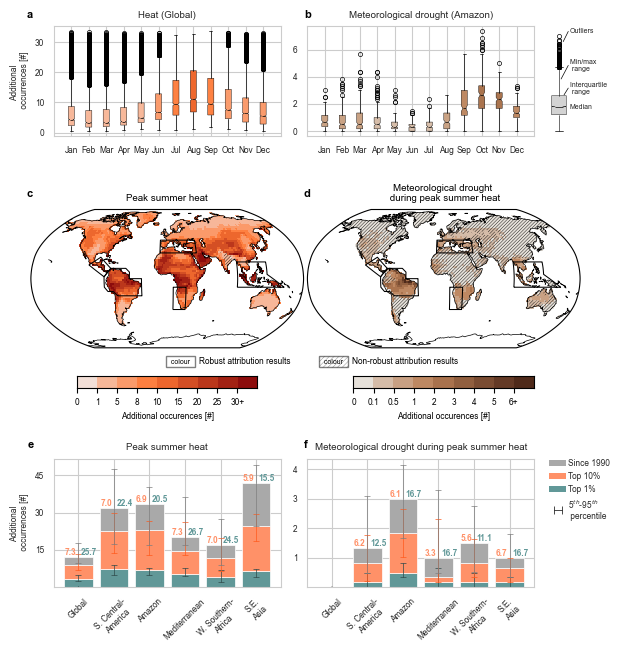

In [ ]:
# make full data: 
sel_regions = [7, 11, 19, 25, 38]
n_regions = len(sel_regions)
region_names = [ar6[region].abbrev for region in sel_regions]
region_names_long = [ar6[region].name for region in sel_regions]
region_names_sep = ['S. Central-\nAmerica',
                    'Amazon',
                    'Mediterranean',
                    'W. Southern-\nAfrica',
                    'S.E.\nAsia'
                    ]

spi_bins = [0,0.1,0.5,1,2,3,4,5,6,8]
spi_bin_labels = ['0', '0.1', '0.5', '1', '2', '3', '4', '5', '6+']
spi_y_ticks = [0,2,4,6]
spi_y_tick_labels = [0,2,4,6]
tas_bins = [0,1,5,8,10,15,20,25,30,35]
tas_bin_labels = ['0', '1', '5', '8', '10', '15', '20', '25', '30+']
tas_y_ticks = [0,10,20,30]
tas_y_tick_labels = [0,10,20,30]

indicator_label = 'Additional occurences [#]'

#import mplotutils as mpu


fig = plt.figure(figsize=(18/2.54, 18.5/2.54))
gs  = GridSpec(30, 24, figure=fig)

axes = []
with sns.axes_style('whitegrid'):
    ax = fig.add_subplot(gs[:6, 1:11])
    tas_boxplot_data = get_boxplot_data('tas', 'hot', 'World')
    make_boxplot(ax, 
                tas_boxplot_data, 
                cmap_tas, 
                tas_bins, 
                tas_y_ticks, 
                tas_y_tick_labels, 
                'Heat (Global)'
                )
    axes.append(ax)

    ax = fig.add_subplot(gs[:6, 12:22])
    spi_boxplot_data = get_boxplot_data('spi', 'dry', 'Amazon')
    make_boxplot(ax, 
                spi_boxplot_data, 
                cmap_spi, 
                spi_bins, 
                spi_y_ticks, 
                spi_y_tick_labels, 
                'Meteorological drought (Amazon)',
                set_y_label = False
                )
    axes.append(ax)
    
    ax_bp_leg = fig.add_subplot(gs[:6, 22:])
    ax = ax_bp_leg
    bplot = ax.boxplot(skewnorm.rvs(7, 0, 1, size = 10000), 
                           positions = [0],
                           widths = 0.35,
                           notch = True,
                           patch_artist = True
                           )
    ax.axis("off")
    for patch, color in zip(bplot['boxes'], ['lightgrey']):
        patch.set_facecolor(color)
        patch.set_edgecolor('black')
        patch.set_linewidth(0.3)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        if element == 'fliers': 
            plt.setp(bplot[element], color='black', markeredgewidth=0.5, markersize = 3)  
        elif element == 'caps':
            plt.setp(bplot[element], color='black', markersize = 5, markeredgewidth = 0.5, lw = 0.5)
        elif element == 'medians': 
             plt.setp(bplot[element], color='black', linewidth = 0.5)  
        else: 
            plt.setp(bplot[element], color='black', linewidth = 0.4)  
    ax.text(0.25, 4, 'Outliers',  rotation = 0, fontsize = fontsize_small, va = 'center', ha = 'left')
    ax.text(0.25, 2.5, 'Min/max \n range',  rotation = 0, fontsize = fontsize_small, va = 'center', ha = 'left')
    ax.text(0.25, 1.5, 'Interquartile \n range', rotation = 0, fontsize = fontsize_small,  va = 'center', ha = 'left')
    ax.text(0.25, 0.65, 'Median', rotation = 0, fontsize = fontsize_small,   va = 'center', ha = 'left')
    ax.plot([0.1, 0.22], [3.55, 4], color = 'black', lw = 0.5)
    ax.plot([0.05, 0.22], [1.9, 2.5], color = 'black', lw = 0.5)
    ax.plot([0.12, 0.22], [1.2, 1.5], color = 'black', lw = 0.5)

ax = fig.add_subplot(gs[9:18, :12], projection=ccrs.Robinson())
legend_ax = fig.add_subplot(gs[17:18, 6:18])
legend_ax.axis('off')
legend_ax.text(0.56, 0, s = " colour ", fontsize = fontsize_small, bbox=dict(facecolor='none', alpha=0.5, hatch="/"*7, boxstyle='square,pad=0.4'), va = 'center')
legend_ax.text(0, 0, s = " colour ", fontsize = fontsize_small, bbox=dict(facecolor='none', alpha=0.5, boxstyle='square,pad=0.4'), va = 'center')
legend_ax.text(0.11, 0, s = 'Robust attribution results', fontsize = fontsize_medium, bbox=dict(facecolor='none', edgecolor = 'none'), va = 'center')
legend_ax.text(0.67, 0, s = 'Non-robust attribution results', fontsize = fontsize_medium, bbox=dict(facecolor='none', edgecolor = 'none'), va = 'center')
# legend_ax.text(0.35, 0, s = " colour ", fontsize = fontsize_small, bbox=dict(facecolor='none', alpha=0.5, hatch="/"*7))
# legend_ax.text(0.35, 0.65, s = " colour ", fontsize = fontsize_small, bbox=dict(facecolor='none', alpha=0.5))
# legend_ax.text(0.5, 0.65, s = 'Robustly attributable results', fontsize = fontsize_small, bbox=dict(facecolor='none', edgecolor = 'none'))
# legend_ax.text(0.5, 0.0, s = 'Non-robust attribution results', fontsize = fontsize_small, bbox=dict(facecolor='none', edgecolor = 'none'))

cbar_ax = fig.add_subplot(gs[18:20, 2:10])
plot_df, z_mean, z_std = data_frequency_peak_month('tas', 'World', 'p90p100', 0.99, 'hot')
plot_map(ax, plot_df.sel(group = 'p90p100'), z_mean, z_std, tas_bins, cmap_tas, sel_regions, title = 'Peak summer heat', amazon = True)
plot_1D_colorbar(cbar_ax, cmap_tas, tas_bins, tas_bin_labels)
axes.append(ax)

ax = fig.add_subplot(gs[9:18, 12:], projection=ccrs.Robinson())
cbar_ax = fig.add_subplot(gs[18:20, 14:-2])
plot_df, z_mean, z_std = data_frequency_peak_month('spi', 'World', 'p90p100', 0.01, 'dry')
plot_map(ax, plot_df.sel(group = 'p90p100'), z_mean, z_std, spi_bins, cmap_spi, sel_regions, title = 'Meteorological drought \n during peak summer heat', amazon = True)
plot_1D_colorbar(cbar_ax, cmap_spi, spi_bins, spi_bin_labels)
axes.append(ax)

with sns.axes_style('whitegrid'):
    ax = fig.add_subplot(gs[23:, 1:11])
    regional_bargraph_plot('tas', 'hot', 0.99, sel_regions, 'Additional \n occurrences [#]', [15,30,45], [15,30,45], np.arange(len(sel_regions)), region_names_sep, 'Peak summer heat', ax, legend = False, amazon = True)
    axes.append(ax)

    ax = fig.add_subplot(gs[23:, 12:22])
    regional_bargraph_plot('spi', 'dry', 0.01, sel_regions, ' \n ', [1,2,3,4], [1,2,3,4], np.arange(len(sel_regions)), region_names_sep, 'Meteorological drought \n during peak summer heat', ax, legend = False, amazon = True)
    axes.append(ax)
    
    ax = fig.add_subplot(gs[23:, 22:])
    ax.axis('off')
    hist_box = patches.Rectangle((0, 0), 1, 1, facecolor=group_colors[0], edgecolor="none")
    top10_box = patches.Rectangle((0, 0), 1, 1, facecolor=group_colors[1], edgecolor="none")
    top1_box = patches.Rectangle((0, 0), 1, 1, facecolor=group_colors[2], edgecolor="none")
    errorbar = ax.errorbar([-0.5], [-0.5], xerr=1, fmt='none', linewidth = 0.5, color='black', capsize=3, capthick=0.5, label = 'Errorbar')
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    h, l = ax.get_legend_handles_labels()
    from matplotlib.legend_handler import HandlerTuple
    # Use the errorbar container as a legend handle
    uncertainty_legend = (errorbar[1][0], errorbar[2], errorbar[1][1])
    # Group the horizontal line and the caps as one legend entry
    ax.legend([hist_box, top10_box, top1_box, uncertainty_legend], 
              ["Since 1990", "Top 10%", 'Top 1%', '5$^{th}$-95$^{th}$ \n percentile'], 
              loc="upper right",
              bbox_to_anchor=(1.7,1),
              edgecolor = 'none',
              facecolor = (1,1,1,0.7),
              fontsize = fontsize_medium,
              handler_map={tuple: HandlerTuple(ndivide=None), 'pad': 0},
              borderpad=-0.5,
              handletextpad = 0.2,
              handlelength = 2
              )
    
lettering = ['a', 'b', 'c', 'd', 'e', 'f']

xs = [-0.12]*1 + [-0.015]*3 + [-0.115]*1 + [-0.015]
ys = [1.15]*6
for i, ax in enumerate(axes):
        ax.text(xs[i], ys[i], lettering[i], transform=axes[i].transAxes, fontsize=fontsize_large+1, fontweight='bold', va='top')

Path(GRAPHICS_PAPER_MAIN_DIR).mkdir(parents=True, exist_ok=True)
plt.savefig(GRAPHICS_PAPER_MAIN_DIR / '003_display_item_revision.pdf', bbox_inches = 'tight', dpi = 600)
print(fig.get_size_inches()*25.4)
plt.show()

[180. 185.]


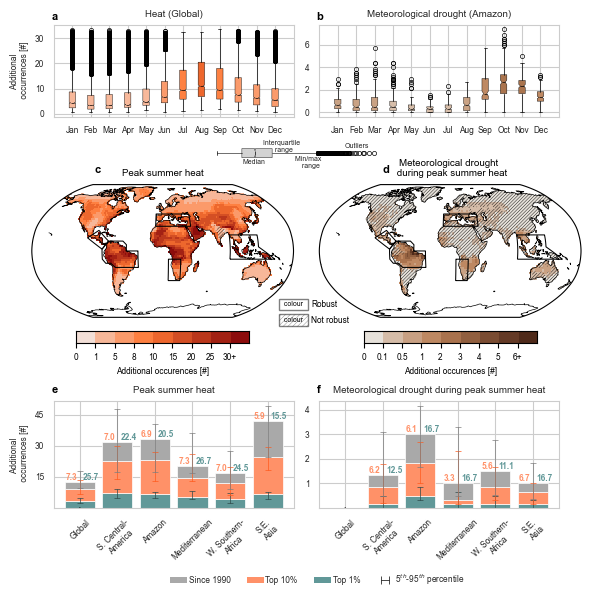

In [141]:
# make full data: 
sel_regions = [7, 11, 19, 25, 38]
n_regions = len(sel_regions)
region_names = [ar6[region].abbrev for region in sel_regions]
region_names_long = [ar6[region].name for region in sel_regions]
region_names_sep = ['S. Central-\nAmerica',
                    'Amazon',
                    'Mediterranean',
                    'W. Southern-\nAfrica',
                    'S.E.\nAsia'
                    ]

spi_bins = [0,0.1,0.5,1,2,3,4,5,6,8]
spi_bin_labels = ['0', '0.1', '0.5', '1', '2', '3', '4', '5', '6+']
spi_y_ticks = [0,2,4,6]
spi_y_tick_labels = [0,2,4,6]
tas_bins = [0,1,5,8,10,15,20,25,30,35]
tas_bin_labels = ['0', '1', '5', '8', '10', '15', '20', '25', '30+']
tas_y_ticks = [0,10,20,30]
tas_y_tick_labels = [0,10,20,30]

indicator_label = 'Additional occurences [#]'

#import mplotutils as mpu


fig = plt.figure(figsize=(18/2.54, 18.5/2.54))
gs  = GridSpec(36, 25, figure=fig)

axes = []
with sns.axes_style('whitegrid'):
    ax = fig.add_subplot(gs[:6, 1:12])
    tas_boxplot_data = get_boxplot_data('tas', 'hot', 'World')
    make_boxplot(ax, 
                tas_boxplot_data, 
                cmap_tas, 
                tas_bins, 
                tas_y_ticks, 
                tas_y_tick_labels, 
                'Heat (Global)'
                )
    axes.append(ax)

    ax = fig.add_subplot(gs[:6, 13:-1])
    spi_boxplot_data = get_boxplot_data('spi', 'dry', 'Amazon')
    make_boxplot(ax, 
                spi_boxplot_data, 
                cmap_spi, 
                spi_bins, 
                spi_y_ticks, 
                spi_y_tick_labels, 
                'Meteorological drought (Amazon)',
                set_y_label = False
                )
    axes.append(ax)
    
    ax_bp_leg = fig.add_subplot(gs[7:9, 8:16])
    ax = ax_bp_leg
    bplot = ax.boxplot(skewnorm.rvs(7, 0, 1, size = 10000), 
                        positions = [0],
                        widths = 0.35,
                        notch = True,
                        patch_artist = True,
                        vert = False
                           )
    ax.axis("off")
    for patch, color in zip(bplot['boxes'], ['lightgrey']):
        patch.set_facecolor(color)
        patch.set_edgecolor('black')
        patch.set_linewidth(0.3)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        if element == 'fliers': 
            plt.setp(bplot[element], color='black', markeredgewidth=0.5, markersize = 3)  
        elif element == 'caps':
            plt.setp(bplot[element], color='black', markersize = 5, markeredgewidth = 0.5, lw = 0.5)
        elif element == 'medians': 
             plt.setp(bplot[element], color='black', linewidth = 0.5)  
        else: 
            plt.setp(bplot[element], color='black', linewidth = 0.4)  
    ax.text(3.5, 0.28, 'Outliers',  rotation = 0, fontsize = fontsize_small, va = 'center', ha = 'center')
    ax.text(2.2, -0.35, 'Min/max \n range',  rotation = 0, fontsize = fontsize_small, va = 'center', ha = 'center')
    ax.text(1.45, 0.28, 'Interquartile \n range',  rotation = 0, fontsize = fontsize_small, va = 'center', ha = 'center')
    ax.text(.65, -.35, 'Median',  rotation = 0, fontsize = fontsize_small, va = 'center', ha = 'center')
    ax.set_ylim(-.4, .7)
    # ax.text(0.25, 1.5, 'Interquartile \n range', rotation = 0, fontsize = fontsize_small,  va = 'center', ha = 'left')
    # ax.text(0.25, 0.65, 'Median', rotation = 0, fontsize = fontsize_small,   va = 'center', ha = 'left')
    # ax.plot([0.1, 0.22], [3.55, 4], color = 'black', lw = 0.5)
    # ax.plot([0.05, 0.22], [1.9, 2.5], color = 'black', lw = 0.5)
    # ax.plot([0.12, 0.22], [1.2, 1.5], color = 'black', lw = 0.5)

ax = fig.add_subplot(gs[10:19, :12], projection=ccrs.Robinson())
legend_ax = fig.add_subplot(gs[18:19, 6:18])
legend_ax.axis('off')
legend_ax.text(0.45, 0, s = " colour ", fontsize = fontsize_small, bbox=dict(facecolor='none', alpha=0.5, hatch="/"*7, boxstyle='square,pad=0.4'), va = 'center')
legend_ax.text(0.45, 1.2, s = " colour ", fontsize = fontsize_small, bbox=dict(facecolor='none', alpha=0.5, boxstyle='square,pad=0.4'), va = 'center')
legend_ax.text(0.56, 1.2, s = 'Robust', fontsize = fontsize_medium, bbox=dict(facecolor='none', edgecolor = 'none'), va = 'center')
legend_ax.text(0.56, 0, s = 'Not robust', fontsize = fontsize_medium, bbox=dict(facecolor='none', edgecolor = 'none'), va = 'center')
# legend_ax.set_ylim(-0.01, 35)
# legend_ax.text(0.35, 0, s = " colour ", fontsize = fontsize_small, bbox=dict(facecolor='none', alpha=0.5, hatch="/"*7))
# legend_ax.text(0.35, 0.65, s = " colour ", fontsize = fontsize_small, bbox=dict(facecolor='none', alpha=0.5))
# legend_ax.text(0.5, 0.65, s = 'Robustly attributable results', fontsize = fontsize_small, bbox=dict(facecolor='none', edgecolor = 'none'))
# legend_ax.text(0.5, 0.0, s = 'Non-robust attribution results', fontsize = fontsize_small, bbox=dict(facecolor='none', edgecolor = 'none'))

cbar_ax = fig.add_subplot(gs[19:21, 2:10])
plot_df, z_mean, z_std = data_frequency_peak_month('tas', 'World', 'p90p100', 0.99, 'hot')
plot_map(ax, plot_df.sel(group = 'p90p100'), z_mean, z_std, tas_bins, cmap_tas, sel_regions, title = 'Peak summer heat', amazon = True)
plot_1D_colorbar(cbar_ax, cmap_tas, tas_bins, tas_bin_labels)
axes.append(ax)

ax = fig.add_subplot(gs[10:19, 13:], projection=ccrs.Robinson())
cbar_ax = fig.add_subplot(gs[19:21, 15:-2])
plot_df, z_mean, z_std = data_frequency_peak_month('spi', 'World', 'p90p100', 0.01, 'dry')
plot_map(ax, plot_df.sel(group = 'p90p100'), z_mean, z_std, spi_bins, cmap_spi, sel_regions, title = 'Meteorological drought \n during peak summer heat', amazon = True)
plot_1D_colorbar(cbar_ax, cmap_spi, spi_bins, spi_bin_labels)
axes.append(ax)

with sns.axes_style('whitegrid'):
    ax = fig.add_subplot(gs[24:-5, 1:12])
    regional_bargraph_plot('tas', 'hot', 0.99, sel_regions, 'Additional \n occurrences [#]', [15,30,45], [15,30,45], np.arange(len(sel_regions)), region_names_sep, 'Peak summer heat', ax, legend = False, amazon = True)
    axes.append(ax)

    ax = fig.add_subplot(gs[24:-5, 13:-1])
    regional_bargraph_plot('spi', 'dry', 0.01, sel_regions, ' \n ', [1,2,3,4], [1,2,3,4], np.arange(len(sel_regions)), region_names_sep, 'Meteorological drought during peak summer heat', ax, legend = False, amazon = True)
    axes.append(ax)
    
    ax = fig.add_subplot(gs[-1:, 8:18])
    ax.axis('off')
    hist_box = patches.Rectangle((0, 0), 1, 1, facecolor=group_colors[0], edgecolor="none")
    top10_box = patches.Rectangle((0, 0), 1, 1, facecolor=group_colors[1], edgecolor="none")
    top1_box = patches.Rectangle((0, 0), 1, 1, facecolor=group_colors[2], edgecolor="none")
    errorbar = ax.errorbar([-0.5], [-0.5], xerr=1, fmt='none', linewidth = 0.5, color='black', capsize=3, capthick=0.5, label = 'Errorbar')
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    h, l = ax.get_legend_handles_labels()
    from matplotlib.legend_handler import HandlerTuple
    # Use the errorbar container as a legend handle
    uncertainty_legend = tuple(h)
    # Group the horizontal line and the caps as one legend entry
    ax.legend([hist_box, top10_box, top1_box, uncertainty_legend], 
              ["Since 1990", "Top 10%", 'Top 1%', '5$^{th}$-95$^{th}$ percentile'], 
              loc="center",
              bbox_to_anchor=(0.5,0.5),
              edgecolor = 'none',
              facecolor = (1,1,1,0.7),
              fontsize = fontsize_medium,
              handler_map={tuple: HandlerTuple(ndivide=None), 'pad': 0},
              borderpad=0.5,
              handletextpad = 0.2,
              handlelength = 2,
              ncols = 4
              )
    
lettering = ['a', 'b', 'c', 'd', 'e', 'f']

xs = [-0.010]*1 + [-0.012] + [0.24]*2 + [-0.010] + [-0.012]
ys = [1.15]*6
for i, ax in enumerate(axes):
        ax.text(xs[i], ys[i], lettering[i], transform=axes[i].transAxes, fontsize=fontsize_large+1, fontweight='bold', va='top')

Path(GRAPHICS_PAPER_MAIN_DIR).mkdir(parents=True, exist_ok=True)
plt.savefig(GRAPHICS_PAPER_MAIN_DIR / '003_display_item_revision.pdf', bbox_inches = 'tight', dpi = 600)
print(fig.get_size_inches()*25.4)
plt.show()

### Appendix

In [42]:

# colors = ["royalblue", "dodgerblue", "teal", 'seagreen', 'gold', 'darkorange', 'lightcoral', 'indianred', 'crimson', 'darkmagenta', 'darkviolet', 'mediumslateblue']

colors = [
    "#1f77b4",  # Blue
    "#2ca02c",  # Green
    "#ffcc00",  # Yellow
    "#ff7f0e",  # Orange
    "#d62728",  # Red
    "#9467bd",  # Purple
    "#1f77b4"   # Back to Blue (to close the cycle)
]
colors = [
    "#336699",  # Muted Deep Blue
    "#488f31",  # Earthy Green
    "#d9ad3c",  # Warm Golden Yellow
    "#d07c40",  # Muted Orange
    "#b33a3a",  # Deep Red
    "#7a4e9e",  # Soft Plum Purple
    "#1f77b4"   # Back to Muted Deep Blue (closing the cycle)
]

cmap_months = LinearSegmentedColormap.from_list("", colors, gamma=0.8)

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

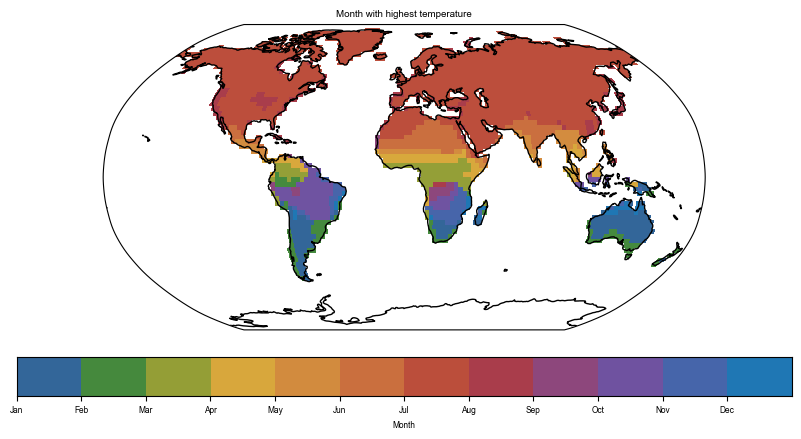

In [43]:
# plotting selected months 
idx_month = np.load(RESULTS_DIR / 'tas_hottest_month.npy')

peak_temperature_months_df = xr.DataArray(data = idx_month, 
                                          dims = ['coords'],
                                          coords = {'coords': ds_coords}).unstack('coords').sortby('lon')

fig = plt.figure(figsize = (10,5))

gs  = GridSpec(5, 2, figure=fig)

axes = []

ax = fig.add_subplot(gs[:4, :], projection=ccrs.Robinson())
cbar_ax = fig.add_subplot(gs[4:, :])

ax.set_global()
ax.coastlines(edgecolor = 'lightgrey')
peak_temperature_months_df.plot(ax=ax, 
            transform = ccrs.PlateCarree(),
            cmap = cmap_months,
            levels  = [0,1,2,3,4,5,6,7,8,9,10,11,12],
            add_colorbar = False,
            extend = 'neither',
            alpha = None)
ax.set_title('Month with highest temperature', fontsize = fontsize_large)
plot_1D_colorbar(cbar_ax, cmap_months, np.arange(13), month_names, indicator_label = 'Month')
Path(GRAPHICS_PAPER_APPENDIX_DIR).mkdir(parents=True, exist_ok=True)
plt.savefig(GRAPHICS_PAPER_APPENDIX_DIR / 'highest_temperature_by_month.pdf', bbox_inches = 'tight', dpi = 600)
plt.show()
